# Deconvolve data measured with a superconducting tip

In [13]:
from SuperconductingTipDeconvolution import STipDeconvolution
import numpy as np
import matplotlib.pyplot as plt

### Demonstration using simulated data

In [14]:
%matplotlib inline

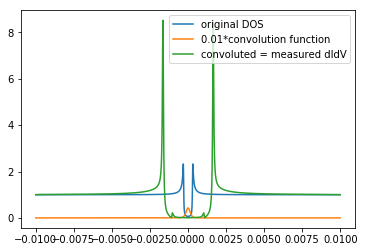

In [15]:
from Physics import BCS
T                   = 1       # temperature in K
Delta               = 1.35e-3   # superconducting gap of the tip in eV
Gamma               = 20e-6     # Dynes parameter in eV

E                   = np.linspace(-10e-3,10e-3,num=2000,endpoint=False)

original            = BCS.DOS(E,0.3e-3,Gamma=20e-6)     # use a second superconductor with smaller gap as a dummy sample
convolution_func    = STipDeconvolution.STip(E=E,bias=0,T=T,Delta=Delta,Gamma=Gamma)

M                   = STipDeconvolution._convolution_matrix(f=lambda e,bias: STipDeconvolution.STip(e,bias,T,Delta,Gamma),E=E,Bias=E)
convoluted          = M @ original

plt.plot(E,original,label='original DOS')
plt.plot(E,0.01*convolution_func,label='0.01*convolution function')
plt.plot(E,1e-5*convoluted,label='convoluted = measured dIdV')
plt.legend()
plt.show()

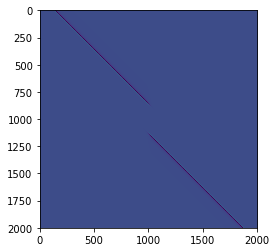

In [16]:
### Take a look at the convolution matrix
plt.imshow(M)

Let us now deconvolve the generated spectrum.

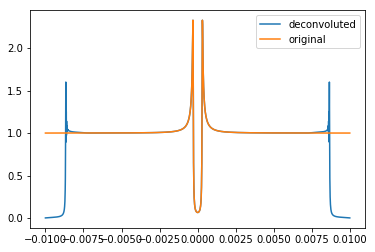

In [17]:
Mdec = STipDeconvolution.deconvolution_matrix(E,T,Delta,Gamma)

deconv = STipDeconvolution.deconvolve(Mdec,convoluted) # or just Mdec @ convoluted

plt.plot(E,deconv,label='deconvoluted')
plt.plot(E,original,label='original')
plt.legend()
plt.show()

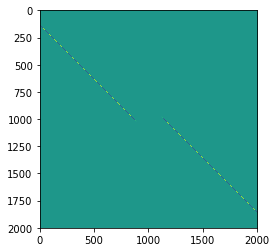

In [18]:
### and the deconvolution matrix
plt.imshow(Mdec)

### Deconvolve experimental data

Start by loading the raw spectrum

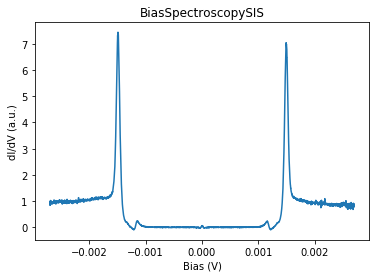

In [19]:
from NanonisMeasurement import NanBiasSpectroscopy

BS = NanBiasSpectroscopy('Example-Data/BiasSpectroscopySIS.dat')
BS_dIdV = BS.get_dIdV()
BS_dIdV.plot_standalone()


In [20]:
# Calculate the deconvolution matrix - this matrix can then be used to deconvolve many spectra, 
# as long as they have been measured with the same tip and are defined on the same energy values.
x_range = [-15e-3,15e-3]
npt = 2000
M = STipDeconvolution.deconvolution_matrix(np.linspace(*x_range,npt),T=50e-3,Delta=1.35e-3,Gamma=20e-6)

d:\DavidWANDER\Codes\Python\DataAnalysisToolbox\Packed\V2.0\Physics.py:96: RuntimeWarning: overflow encountered in exp
  return -1/(kB_eV*T*(np.exp(-E/(kB_eV*T))+2+np.exp(E/(kB_eV*T))))
d:\DavidWANDER\Codes\Python\DataAnalysisToolbox\Packed\V2.0\Physics.py:87: RuntimeWarning: overflow encountered in exp
  return 1/(np.exp((E-mu)/(kB_eV*T))+1)


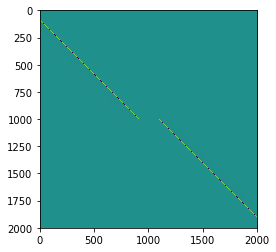

In [21]:
plt.imshow(M)

In [22]:
# strech the experimental data to a larger x range to avoid boundary problems and reduce its number of points
x,y = STipDeconvolution.streched_and_reduced_curve(BS_dIdV,x_range=x_range,n_pts=npt)

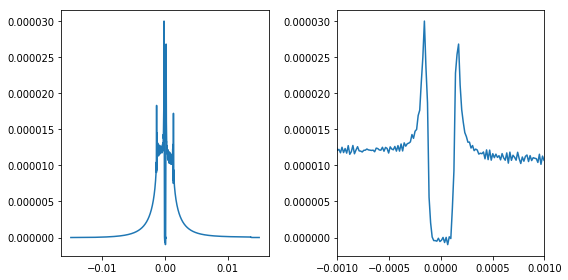

In [33]:
y_decon = STipDeconvolution.deconvolve(M,y)
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(8,4))
ax1.plot(x,y_decon)
ax2.plot(x,y_decon)
ax2.set_xlim(-1e-3,1e-3)

fig.tight_layout()

### Pitfalls

#### Too small streched range

In [39]:
x_range = [-12e-3,12e-3]
npt = 2000
M = STipDeconvolution.deconvolution_matrix(np.linspace(*x_range,npt),T=50e-3,Delta=1.35e-3,Gamma=20e-6)
x,y = STipDeconvolution.streched_and_reduced_curve(BS_dIdV,x_range=x_range,n_pts=npt)

y_decon = STipDeconvolution.deconvolve(M,y)


d:\DavidWANDER\Codes\Python\DataAnalysisToolbox\Packed\V2.0\Physics.py:96: RuntimeWarning: overflow encountered in exp
  return -1/(kB_eV*T*(np.exp(-E/(kB_eV*T))+2+np.exp(E/(kB_eV*T))))
d:\DavidWANDER\Codes\Python\DataAnalysisToolbox\Packed\V2.0\Physics.py:87: RuntimeWarning: overflow encountered in exp
  return 1/(np.exp((E-mu)/(kB_eV*T))+1)


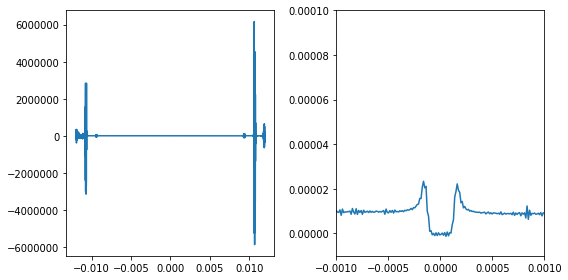

In [43]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(8,4))
# left: full data
ax1.plot(x,y_decon)

# right: zoom (a lot!) on the origin
ax2.plot(x,y_decon)
ax2.set_xlim(-1e-3,1e-3)
ax2.set_ylim(-1e-5,1e-4)

fig.tight_layout()

If the data is steched over a too small range, huge artefacts are generated at both sides of the deconvoluted curve.

#### Too large resolution
If the input data contains too many data points, the execution becomes very slow (the matrix inversion scales as n^2.37 at the best).
On some systems we also observed that the python kernel crashes for n>2000.